# Sparse inverse covariance estimation with MFCF and cross-validation
Code is adpated from the scikit-learn [example](https://scikit-learn.org/stable/auto_examples/covariance/plot_sparse_cov.html#sphx-glr-auto-examples-covariance-plot-sparse-cov-py)

In [18]:
# Generate the data
# -----------------
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix

n_samples = 100
n_features = 25

prng = np.random.RandomState(2025)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.95, smallest_coef=0.25, largest_coef=0.75, random_state=prng
)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [19]:
# Estimate the covariance
# -----------------------
from sklearn.covariance import GraphicalLassoCV
from mfcf_covariance import MFCFCovarianceCV

emp_cov = np.dot(X.T, X) / n_samples


model = GraphicalLassoCV()
model.fit(X)
gl_cov_ = model.covariance_
gl_prec_ = model.precision_

# MFCFCV
model = MFCFCovarianceCV(max_clique_size_grid=n_features)
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

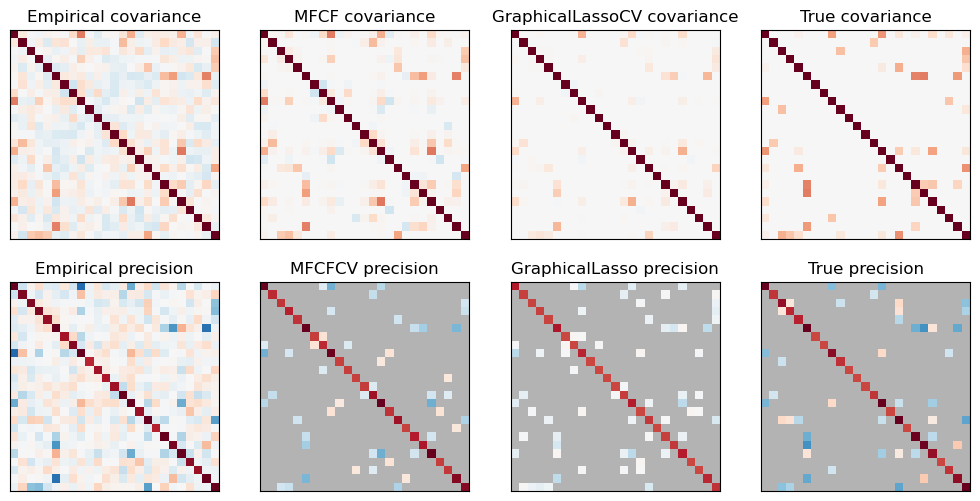

In [20]:
# Plot the results
# ----------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [
    ("Empirical", emp_cov),
    ("MFCF", cov_),
    ("GraphicalLassoCV", gl_cov_),
    ("True", cov),
]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s covariance" % name)

# plot the precisions
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("MFCFCV", prec_),
    ("GraphicalLasso", gl_prec_),
    ("True", prec),
]
vmax = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % name)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")

In [21]:
print(model.best_max_clique_size_)
model.cv_results_

2


{'params': [{'max_clique_size': 2},
  {'max_clique_size': 3},
  {'max_clique_size': 4},
  {'max_clique_size': 5},
  {'max_clique_size': 6},
  {'max_clique_size': 7},
  {'max_clique_size': 8},
  {'max_clique_size': 9},
  {'max_clique_size': 10},
  {'max_clique_size': 11},
  {'max_clique_size': 12},
  {'max_clique_size': 13},
  {'max_clique_size': 14},
  {'max_clique_size': 15},
  {'max_clique_size': 16},
  {'max_clique_size': 17},
  {'max_clique_size': 18},
  {'max_clique_size': 19},
  {'max_clique_size': 20},
  {'max_clique_size': 21},
  {'max_clique_size': 22},
  {'max_clique_size': 23},
  {'max_clique_size': 24},
  {'max_clique_size': 25}],
 'mean_test_score': array([-34.77779303, -34.80777494, -34.88705446, -35.17754182,
        -35.48350212, -35.49776289, -35.63413272, -35.97162278,
        -36.08196025, -36.20101907, -36.38963508, -36.45523187,
        -36.82309091, -36.95698878, -37.21801655, -37.27451775,
        -37.38020497, -37.42494967, -37.56498146, -37.72854604,
        -3

## Compare log likelihoods of MFCFCV and GraphicalLassoCV

In [22]:
from sklearn.covariance import log_likelihood
print("MFCFCV log likelihood: %.3f" % log_likelihood(emp_cov, prec))
print("GraphicalLassoCV log likelihood: %.3f" % log_likelihood(emp_cov, gl_prec_))

MFCFCV log likelihood: -34.419
GraphicalLassoCV log likelihood: -34.586
